# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *
from online_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# rides = pd.read_csv('../data/rideshare_kaggle.csv')
# rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

# new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
# new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
# new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

# cab_types_ = new_rides.cab_type.unique()
# distances_ = new_rides.distance.unique()
# hours_ = np.array([16,17,18,19,20])  # new_rides.hour.unique()
# prices_ = np.array([5*(i) for i in range(10)])  # new_rides.price.unique()
# dates = len(new_rides.date.unique())

# g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

# for i in range(len(cab_types_)):
#     for j in trange(len(prices_)):
#         for k in range(len(hours_)):
#             for m in range(len(distances_)):
#                 g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
#                                           &(new_rides['price']==prices_[j])
#                                           &(new_rides['hour']==hours_[k])
#                                           &(new_rides['distance']==distances_[m])])/dates

# np.random.seed(37)

In [3]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['source','destination','cab_type','price','date']].dropna(subset = ['price']).reset_index()
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
sources_ = new_rides.source.unique()
destinations_ = new_rides.destination.unique()
prices_ = np.array([5*(i+1) for i in range(5)])
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(sources_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(sources_)):
                g[i,j,k] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                            &(new_rides['price']==prices_[j])
                                            &(new_rides['source']==sources_[k])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


# Configurations

In [4]:
g_uber = g[np.where(cab_types_=='Uber'),:,:].squeeze().reshape(-1,1)
g_lyft = g[np.where(cab_types_=='Lyft'),:,:].squeeze().reshape(-1,1)

prices_ = np.array([5*(i+1) for i in range(5)])
prices_ = (prices_.reshape((-1,1))*np.ones((len(prices_),len(sources_)))).reshape(-1,1)

# print(f'g_uber = \n{g_uber}')
# print(f'g_lyft = \n{g_lyft}')
# print(prices_)

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e0
lambda_p2 = 1e0

eta_p1 = 1e-2
eta_p2 = 1e-2

mu_p1 = -0.07*g_uber
gamma_p1 = 0.02*g_uber
mu_p2 = -0.07*g_lyft
gamma_p2 = 0.02*g_lyft

# print(f'mu_1 = \n{mu_p1}')
# print(f'gamma_1 = \n{gamma_p1}')
# print(f'mu_2 = \n{mu_p2}')
# print(f'gamma_2 = \n{gamma_p2}')

In [5]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [6]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_test = 1000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [7]:
np.random.seed(0)
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_samples in num_rounds_lst:
    print(f"num_samples = {num_samples}")
    rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
    rounds_2 = num_samples-rounds_1
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds=rounds_1, num_alternate_rounds=rounds_2, num_test=1000)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_samples = 10
---------------------
Player 1: mu error
282.38592476750335
Player 1: gamma error
429.89306263377233
Player 1 Risk:
-213382.6912148285
Player 2: mu error
259.03052589269606
Player 2: gamma error
287.0862465446537
Player 2 Risk:
-198749.4677211573
---------------------
num_samples = 100
---------------------
Player 1: mu error
25.27737606226114
Player 1: gamma error
24.110572735450738
Player 1 Risk:
-231234.61046603107
Player 2: mu error
18.901341121461652
Player 2: gamma error
21.226617954058366
Player 2 Risk:
-205386.24153567987
---------------------
num_samples = 1000
---------------------
Player 1: mu error
7.242261628377539
Player 1: gamma error
6.366916293389475
Player 1 Risk:
-231145.8249640251
Player 2: mu error
7.119472441934254
Player 2: gamma error
6.0616348019462905
Player 2 Risk:
-209112.83371076442
---------------------
num_samples = 10000
---------------------
Player 1: mu error
2.0631810176858774
Player 1: gamma error
1.9523473875777866
Player 1 Risk:
-2

# Run game with DFO players

In [8]:
np.random.seed(0)
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 4e-1
eta = 1e-2#1e-1 best so far
num_test_dfo = 100
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test = num_test_dfo)

# print(game_dfo.theta_p1)

for i in trange(math.ceil(num_rounds/2/num_test_dfo)+1):

    theta31, theta32 = player_three.perturb_theta()
    theta41, theta42 = player_four.perturb_theta()
    
    game_dfo.theta_p1 = theta31
    game_dfo.theta_p2 = theta41
    pr31 = game_dfo.evaluate_perf_risk_p1()
    pr41 = game_dfo.evaluate_perf_risk_p2()
    
    game_dfo.theta_p1 = theta32
    game_dfo.theta_p2 = theta42
    pr32 = game_dfo.evaluate_perf_risk_p1()
    pr42 = game_dfo.evaluate_perf_risk_p2()
#     print(pr31)
#     print(pr32)
    
    game_dfo.theta_p1 = player_three.update_theta(pr31, pr32)
    game_dfo.theta_p2 = player_four.update_theta(pr41, pr42)
#     print(game_dfo.theta_p1)
    
    if i*2*num_test_dfo >= num_rounds_lst[len(p3_risks)]:
#         p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
#                                                    mu_p1, gamma_p1,
#                                                    lambda_p1,
#                                                    game_dfo.theta_p1, game_dfo.theta_p2,
#                                                    num_test))
#         p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
#                                                    mu_p2, gamma_p2,
#                                                    lambda_p2,
#                                                    game_dfo.theta_p2, game_dfo.theta_p1,
#                                                    num_test))
        p3_risks.append(np.mean(np.array(game_dfo.p1.risk_history[max(-i,-1000)])))
        p4_risks.append(np.mean(np.array(game_dfo.p2.risk_history[max(-i,-1000)])))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)

        if True:
            print("---------------------")
            print(f"Iteration {i*2*num_test_dfo}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

  8%|██████▋                                                                         | 42/501 [00:00<00:01, 415.27it/s]

---------------------
Iteration 200
Player 3 risk:
-208250.9738684823
Player 4 risk:
-198891.58318027345
---------------------
---------------------
Iteration 400
Player 3 risk:
-212458.56226346095
Player 4 risk:
-190526.93402929246
---------------------
---------------------
Iteration 1000
Player 3 risk:
-212890.5614526678
Player 4 risk:
-190437.4215856517
---------------------
---------------------
Iteration 10000
Player 3 risk:
-217072.91514218497
Player 4 risk:
-190579.78133280296
---------------------


100%|███████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 531.62it/s]

---------------------
Iteration 100000
Player 3 risk:
-216849.91076457757
Player 4 risk:
-191875.02140684478
---------------------


# Run game with Online players

In [9]:
np.random.seed(0)
p5_risks = []
p6_risks = []
theta_final_p5 = []
theta_final_p6 = []

nu = 1e-2
eta = 1e-1
n = 100
B = 0.1
R = 5
num_rounds = num_rounds_lst[-1]

player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
game_online = DecisionDependentGame(player_five, player_six,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test = 1000)

for i in trange(math.ceil(num_rounds/(n))+1):

    theta_5, u_5k = player_five.perturb_theta()
    theta_6, u_6k = player_six.perturb_theta()
#     print(f'theta {theta_5.shape}')
    
    z_5k = []
    z_6k = []
    for j in range(n):
        game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
        game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))
        
        z_5k.append(game_online.oracle_z1())
        z_6k.append(game_online.oracle_z2())
        
#     print(f'z {len(z_5k)}')
        
    q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
    q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
#     print(f'q {q_5k.shape}')
    
    p_5 = player_five.update_p()
    p_6 = player_six.update_p()
#     print(f'p {p_5.shape}')
    
    grad_5 = game_online.oracle_grad1(p_5, q_5k)
    grad_6 = game_online.oracle_grad2(p_6, q_6k)
#     print(f'grad {grad_5.shape}')
    
    game_online.theta_p1 = player_five.update_theta(grad_5)
    game_online.theta_p2 = player_six.update_theta(grad_6)
#     print(f'theta {game_online.theta_p1.shape}')
    
    if i*n >= num_rounds_lst[len(p5_risks)]:
        p5_risks.append(game_online.evaluate_perf_risk_p1())
        p6_risks.append(game_online.evaluate_perf_risk_p2())
        
        theta_final_p5.append(game_dfo.theta_p1)
        theta_final_p6.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i*n}")
            print("Player 5: mu error")
            print(np.linalg.norm(mu_p1-p_5[:,:d_1].reshape((-1,1))))
            print("Player 5: gamma error")
            print(np.linalg.norm(gamma_p1-p_5[:,d_1:].reshape((-1,1))))
            print("Player 5 risk:")
            print(p5_risks[-1])

            print("Player 6: mu error")
            print(np.linalg.norm(mu_p2-p_6[:,:d_2].reshape((-1,1))))
            print("Player 6: gamma error")
            print(np.linalg.norm(gamma_p2-p_6[:,d_2:].reshape((-1,1))))
            print("Player 6 risk:")
            print(p6_risks[-1])
            print("---------------------")

  1%|▊                                                                               | 10/1001 [00:00<00:10, 96.43it/s]

---------------------
Iteration 100
Player 5: mu error
185.07114111436127
Player 5: gamma error
50.643660437748636
Player 5 risk:
-216555.34093717588
Player 6: mu error
147.57526136439478
Player 6: gamma error
40.35050671198731
Player 6 risk:
-198659.5981928759
---------------------
---------------------
Iteration 200
Player 5: mu error
190.35601457089564
Player 5: gamma error
48.03170334135406
Player 5 risk:
-218171.45869962996
Player 6: mu error
149.67913679407093
Player 6: gamma error
38.041531976568535
Player 6 risk:
-199498.0398923205
---------------------
---------------------
Iteration 1000
Player 5: mu error
196.3393230374366
Player 5: gamma error
53.09768550503011
Player 5 risk:
-225263.5279059977
Player 6: mu error
157.4246638519084
Player 6: gamma error
48.218957034109216
Player 6 risk:
-203993.18077728106
---------------------


 12%|█████████▏                                                                    | 118/1001 [00:00<00:07, 122.50it/s]

---------------------
Iteration 10000
Player 5: mu error
193.39295821691462
Player 5: gamma error
58.94208673712983
Player 5 risk:
-230141.41784379433
Player 6: mu error
153.06825514301113
Player 6: gamma error
55.91336517807109
Player 6 risk:
-208697.47193021924
---------------------


100%|█████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:07<00:00, 130.89it/s]

---------------------
Iteration 100000
Player 5: mu error
193.39295821691462
Player 5: gamma error
58.94208673712983
Player 5 risk:
-230753.3731630653
Player 6: mu error
153.06825514301113
Player 6: gamma error
55.91336517807109
Player 6 risk:
-208535.1960912745
---------------------


## Plots

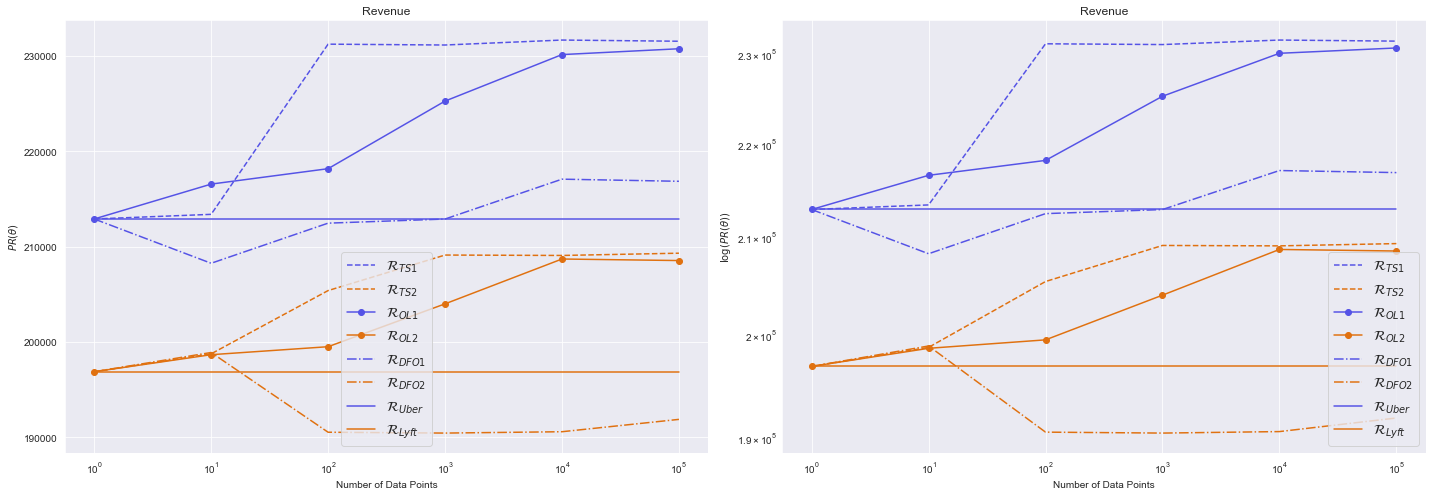

In [10]:
base_uber = -np.dot(g_uber.T,prices_)[0,0]
base_lyft = -np.dot(g_lyft.T,prices_)[0,0]

num_rounds_lst_ = num_rounds_lst

num_rounds_lst_ = np.insert(num_rounds_lst,0,1)
p1_risks_ = np.insert(p1_risks, 0, base_uber)
p2_risks_ = np.insert(p2_risks, 0, base_lyft)
p3_risks_ = np.insert(p3_risks, 0, base_uber)
p4_risks_ = np.insert(p4_risks, 0, base_lyft)
p5_risks_ = np.insert(p5_risks, 0, base_uber)
p6_risks_ = np.insert(p6_risks, 0, base_lyft)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst_, -np.squeeze(p1_risks_),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p2_risks_),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst_, -np.squeeze(p5_risks_),
             '-o', color='#5553E6', label=r'$\mathcal{R}_{OL1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p6_risks_),
             '-o', color='#E07110', label=r'$\mathcal{R}_{OL2}$')

plt.semilogx(num_rounds_lst_, -np.squeeze(p3_risks_),
             '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p4_risks_),
             '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.semilogx(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.semilogx(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst_, -np.squeeze(p1_risks_),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst_, -np.squeeze(p2_risks_),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst_, -np.squeeze(p5_risks_),
           '-o', color='#5553E6', label=r'$\mathcal{R}_{OL1}$')
plt.loglog(num_rounds_lst_, -np.squeeze(p6_risks_),
           '-o', color='#E07110', label=r'$\mathcal{R}_{OL2}$')

plt.loglog(num_rounds_lst_, -np.squeeze(p3_risks_),
             '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst_, -np.squeeze(p4_risks_),
             '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.loglog(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.loglog(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Strategies')
# plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

In [18]:
print(f'theta_1_ol - theta_1_ts = \n{np.linalg.norm(game_online.theta_p1-game_ts.theta_p1)}')
print(f'theta_2_ol - theta_2_ts = \n{np.linalg.norm(game_online.theta_p2-game_ts.theta_p2)}')

theta_1_ol - theta_1_ts = 
0.6979560520246917
theta_2_ol - theta_2_ts = 
6.084963359407906


In [12]:
print(f'theta_1_ts = \n{game_ts.theta_p1.T}')
print(f'theta_2_ts = \n{game_ts.theta_p2.T}')

theta_1_ts = 
[[ 5.          5.          5.          5.          5.          5.
   5.          5.          5.          5.          5.          5.
   2.5669782   2.50463257  2.49066682  2.44447599  2.42573421  2.5068693
   2.49461711  2.49587198  2.4522892   2.48398776  2.50925165  2.52942063
  -0.36401725 -0.32483666 -0.33539355 -0.35126222 -0.35604375 -0.30061355
  -0.30286491 -0.30783965 -0.34891337 -0.32706713 -0.35160616 -0.33773681
  -2.34561564 -3.06852122 -2.59213799 -2.907727   -2.97291841 -3.08723828
  -3.13837428 -2.95397838 -2.92542458 -2.9532891  -2.87806    -3.03330078
  -5.         -5.         -5.         -5.         -5.         -5.
  -5.         -5.         -5.         -5.         -5.         -5.        ]]
theta_2_ts = 
[[ 5.          5.          5.          5.          5.          5.
   5.          5.          5.          5.          5.          5.
   2.44544202  2.44551415  2.40268886  2.38204786  2.44116694  2.4445737
   2.40967588  2.41385099  2.36411645  2.43088643 

In [13]:
print(f'theta_1_ol = \n{game_online.theta_p1.T}')
print(f'theta_2_ol = \n{game_online.theta_p2.T}')

theta_1_ol = 
[[ 5.          5.          5.          5.          5.          5.
   5.          5.          5.          5.          5.          5.
   2.41919849  2.47163101  2.48477089  2.43285867  2.46473823  2.45828132
   2.45695695  2.42019605  2.42835507  2.45779084  2.47781075  2.46114381
  -0.41075189 -0.39883806 -0.40644852 -0.40316222 -0.39841178 -0.40330107
  -0.39224232 -0.38043409 -0.40611918 -0.3883196  -0.38717775 -0.38375513
  -2.69314923 -3.16173167 -2.91357267 -3.02787736 -3.11075412 -3.18107702
  -3.16330216 -3.0749823  -3.10817218 -3.12325838 -3.06416377 -3.11983077
  -5.         -5.         -5.         -5.         -5.         -5.
  -5.         -5.         -5.         -5.         -5.         -5.        ]]
theta_2_ol = 
[[ 5.          5.          5.          5.          5.          5.
   5.          5.          5.          5.          5.          5.
   4.86284628  1.94537377  2.11166513  1.23586804  2.28527881  1.18321836
   1.04514371  1.83929555  2.21092441  1.2119149

In [14]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1.T}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2.T}')

theta_1_dfo = 
[[ 8.73731435e-01  6.43959599e-01  3.19371675e+00  2.43000347e+00
   1.25567153e+00 -2.70227720e+00  3.43695358e+00  1.09398111e+00
   2.86594787e+00  2.90092397e+00 -7.94346858e-01 -2.21079465e+00
   2.20144608e+00 -4.40041211e+00 -7.51263241e-01  4.46433409e+00
  -1.14383872e+00 -3.21843076e+00 -1.50608009e+00  1.17751843e+00
   4.12572597e+00  4.82813930e+00  1.92667132e+00 -1.25867152e-01
  -4.93758104e-01 -2.65436274e+00 -1.91570594e+00 -4.58191123e+00
   2.42261548e+00  2.48752612e+00 -3.70322023e+00 -8.46014504e-01
   2.43262247e+00  4.99112968e+00 -1.55272937e+00 -4.02084542e+00
   3.09764507e+00 -5.04740957e-01 -3.75804927e+00 -4.50817555e+00
   3.31502676e+00 -3.66688793e+00 -2.24239244e+00 -1.80248836e+00
  -2.02068346e-04  3.62776515e+00 -4.57773408e+00  3.73261731e+00
  -1.68369887e-01 -4.79545991e+00 -9.27938204e-01 -2.42557283e-01
  -3.43485477e+00 -2.61937810e+00 -4.11977719e+00 -2.23269770e+00
  -2.17894247e+00 -1.27796417e+00 -1.70493574e+00 -4.40993072

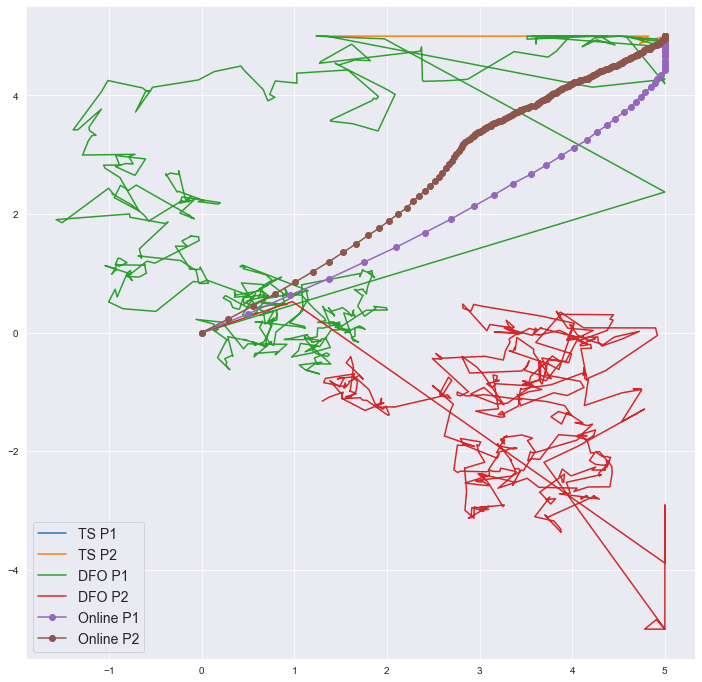

In [15]:
plt.figure(figsize=(12,12))
plt.plot(np.array(theta_final_p1)[:,0].squeeze(),
         np.array(theta_final_p1)[:,1].squeeze(), label='TS P1')
plt.plot(np.array(theta_final_p2)[:,0].squeeze(),
         np.array(theta_final_p2)[:,1].squeeze(), label='TS P2')
plt.plot(np.array(game_dfo.p1.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p1.theta_history)[:,1].squeeze(), label='DFO P1')
plt.plot(np.array(game_dfo.p2.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p2.theta_history)[:,1].squeeze(), label='DFO P2')
plt.plot(np.array(game_online.p1.theta_history)[:,0].squeeze(),
         np.array(game_online.p1.theta_history)[:,1].squeeze(), '-o', label='Online P1')
plt.plot(np.array(game_online.p2.theta_history)[:,0].squeeze(),
         np.array(game_online.p2.theta_history)[:,1].squeeze(), '-o', label='Online P2')
# plt.xlim(-5.1,5.1)
# plt.ylim(-5.1,5.1)
plt.legend(fontsize=14)
plt.savefig('DD_regression_rideshare_trajectory.jpg', format='jpg')
plt.show()

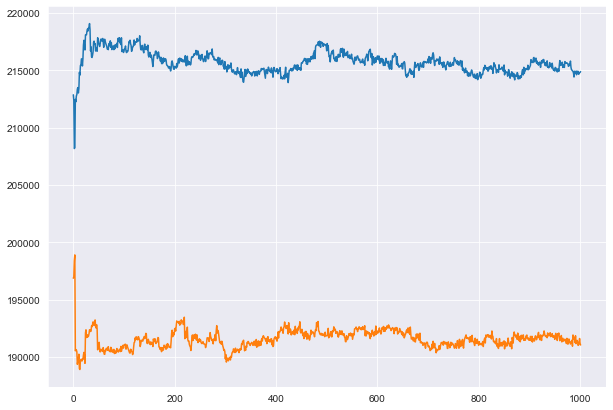

In [16]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

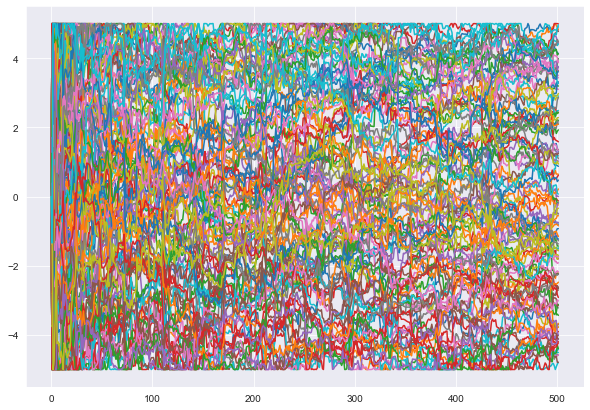

In [17]:
plt.figure(figsize=(10,7))
plt.plot(np.squeeze(game_dfo.p1.theta_history))
plt.plot(np.squeeze(game_dfo.p2.theta_history))
plt.show()